In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
df=pd.read_csv("synthetic_weather_data_wo_label_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)
df_labeled=pd.read_csv("synthetic_weather_data_wi_label_supervised_30anomalyinjected.csv",header=0, index_col=0, parse_dates=True)

### 1 year and 30 anomalies

In [3]:
# Not on same scale and need to split the data to the train and test part 
Ntest = 365   # 1 year
train= df.iloc[:-Ntest].copy()
test= df.iloc[-Ntest:].copy()

scaler_temp= RobustScaler()
train['ScaledTemp'] = scaler_temp.fit_transform(train[['temperature']])
test['ScaledTemp'] = scaler_temp.transform(test[['temperature']])

scaler_humid= RobustScaler()
train['ScaledHumid'] = scaler_humid.fit_transform(train[['humidity']])
test['ScaledHumid'] = scaler_humid.transform(test[['humidity']])

scaler_pressure= RobustScaler()
train['ScaledPressure'] = scaler_pressure.fit_transform(train[['pressure']])
test['ScaledPressure'] = scaler_pressure.transform(test[['pressure']])

train_idx = df.index <=train.index[-1]
test_idx = df.index > train.index[-1]

df.loc[train_idx, 'ScaledTemp']= train['ScaledTemp']
df.loc[test_idx, 'ScaledTemp']= test['ScaledTemp']

df.loc[train_idx, 'ScaledHumid']= train['ScaledHumid']
df.loc[test_idx, 'ScaledHumid']= test['ScaledHumid']

df.loc[train_idx, 'ScaledPressure']= train['ScaledPressure']
df.loc[test_idx, 'ScaledPressure']= test['ScaledPressure']

<AxesSubplot: xlabel='date'>

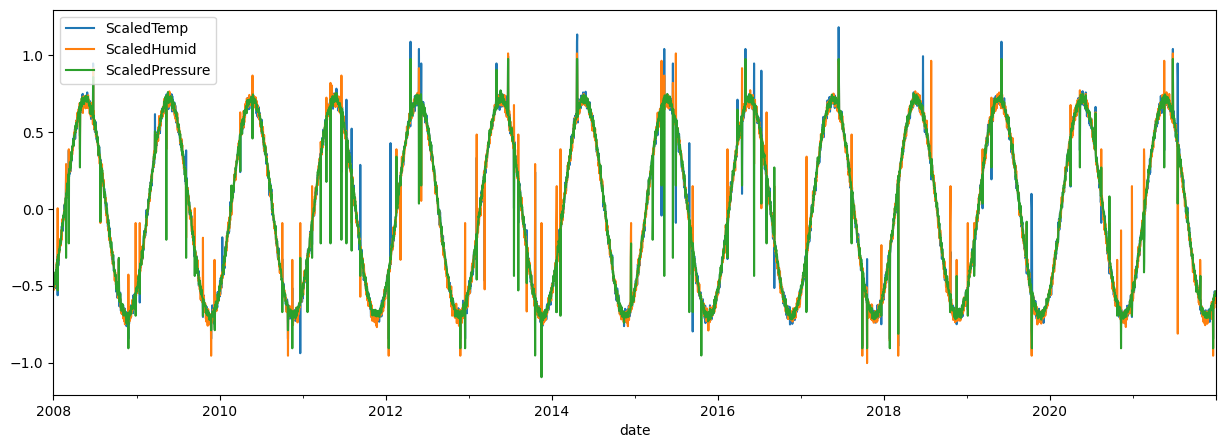

In [4]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
train[cols].plot(figsize=(15,5))

<AxesSubplot: xlabel='date'>

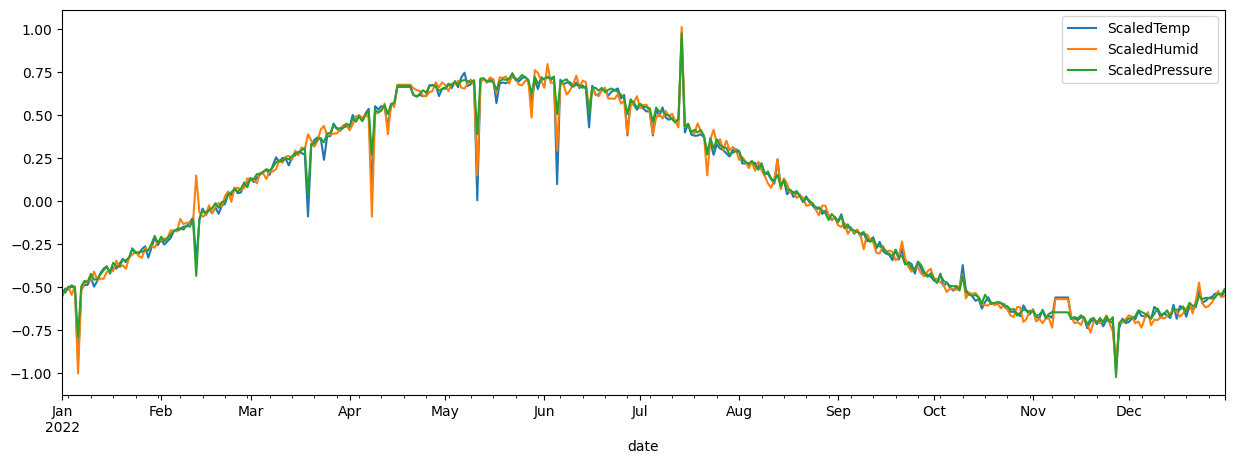

In [5]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
test[cols].plot(figsize=(15,5))

In [6]:
df_combined=[train[cols],test[cols]]
df_combined=pd.concat(df_combined, axis=0)

In [7]:
for i in range(1, 8):
    df_combined[f'ST_t-{i}'] = df_combined['ScaledTemp'].shift(i)

In [8]:
for i in range(1, 8):
    df_combined[f'SH_t-{i}'] = df_combined['ScaledHumid'].shift(i)

In [9]:
for i in range(1, 8):
    df_combined[f'SP_t-{i}'] = df_combined['ScaledPressure'].shift(i)

In [10]:
df_combined = df_combined.dropna()

In [11]:
# Not on same scale and need to split the data to the train and test part 
nest_samples = 365  # 1 year
train_data = df_combined.iloc[:-nest_samples].copy()
test_data = df_combined.iloc[-nest_samples:].copy()

In [12]:
features = [col for col in df_combined.columns if col not in ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]
X_train, y_train = train_data[features], train_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']] #Split into X and Y. training data.

In [13]:
X_train

,ST_t-1,ST_t-2,ST_t-3,ST_t-4,ST_t-5,ST_t-6,ST_t-7,SH_t-1,SH_t-2,SH_t-3,...,SH_t-5,SH_t-6,SH_t-7,SP_t-1,SP_t-2,SP_t-3,SP_t-4,SP_t-5,SP_t-6,SP_t-7
date,,,,,,,,,,,,,,,,,,,,,
2008-01-08,-0.506180,-0.502413,-0.487816,-0.500059,-0.498646,-0.513243,-0.472278,-0.505152,-0.486461,-0.509466,...,-0.517613,-0.515696,-0.519051,-0.484866,-0.493329,-0.480165,-0.508375,-0.487922,-0.505789,-0.501793
2008-01-09,-0.462861,-0.506180,-0.502413,-0.487816,-0.500059,-0.498646,-0.513243,-0.494129,-0.505152,-0.486461,...,-0.526719,-0.517613,-0.515696,-0.448428,-0.484866,-0.493329,-0.480165,-0.508375,-0.487922,-0.505789
2008-01-10,-0.515597,-0.462861,-0.506180,-0.502413,-0.487816,-0.500059,-0.498646,-0.461059,-0.494129,-0.505152,...,-0.509466,-0.526719,-0.517613,-0.488158,-0.448428,-0.484866,-0.493329,-0.480165,-0.508375,-0.487922
2008-01-11,-0.441672,-0.515597,-0.462861,-0.506180,-0.502413,-0.487816,-0.500059,-0.455787,-0.461059,-0.494129,...,-0.486461,-0.509466,-0.526719,-0.445372,-0.488158,-0.448428,-0.484866,-0.493329,-0.480165,-0.508375
2008-01-12,-0.437434,-0.441672,-0.515597,-0.462861,-0.506180,-0.502413,-0.487816,-0.427510,-0.455787,-0.461059,...,-0.505152,-0.486461,-0.509466,-0.410344,-0.445372,-0.488158,-0.448428,-0.484866,-0.493329,-0.480165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-0.536315,-0.608829,-0.584815,-0.574926,-0.575397,-0.584344,-0.626251,-0.603403,-0.585191,-0.643662,...,-0.583753,-0.645579,-0.641265,-0.557508,-0.565501,-0.562210,-0.565501,-0.591596,-0.582662,-0.623803
2021-12-28,-0.582931,-0.536315,-0.608829,-0.584815,-0.574926,-0.575397,-0.584344,-0.612030,-0.603403,-0.585191,...,-0.608675,-0.583753,-0.645579,-0.567382,-0.557508,-0.565501,-0.562210,-0.565501,-0.591596,-0.582662
2021-12-29,-0.556092,-0.582931,-0.536315,-0.608829,-0.584815,-0.574926,-0.575397,-0.585670,-0.612030,-0.603403,...,-0.643662,-0.608675,-0.583753,-0.562445,-0.567382,-0.557508,-0.565501,-0.562210,-0.565501,-0.591596


In [14]:
x_test, y_test = test_data[features], test_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]

In [15]:
rf = RandomForestRegressor()
#n_estimators=100, random_state=42

In [16]:
models = []
for i in range(3):
    model = rf
    model.fit(X_train, y_train.iloc[:, i])
    models.append(model)

In [17]:
# Make predictions on the test set for each target variable
y_pred_train = []
for i in range(3):
    y_pred_train.append(models[i].predict(X_train))

In [18]:
# Make predictions on the test set for each target variable
y_pred = []
for i in range(3):
    y_pred.append(models[i].predict(x_test))

In [19]:
# Combine the predictions into a single dataframe on training prediction
df_prediction_train = pd.DataFrame({'Predicted_temperature': y_pred_train[0], 'Predicted_humidity': y_pred_train[1], 'Predicted_pressure': y_pred_train[2]}, index=X_train.index)

In [20]:
# Combine the predictions into a single dataframe
df_prediction = pd.DataFrame({'Predicted_temperature': y_pred[0], 'Predicted_humidity': y_pred[1], 'Predicted_pressure': y_pred[2]}, index=x_test.index)

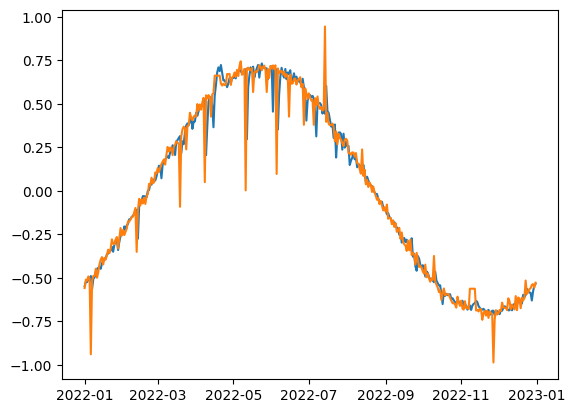

In [21]:
import matplotlib.pyplot as plt
plt.plot(df_prediction['Predicted_temperature'])
plt.plot(y_test['ScaledTemp'])
#plt.plot(df_prediction_train['Predicted_temperature'])

In [22]:
#test_data(Predicted+actual)
data_temp_test = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp']})
data_humidity_test = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid']})
data_pressure_test = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure']})
data_kNN_test=pd.concat([data_temp_test,data_humidity_test,data_pressure_test],axis=1)

In [23]:
nest_samples=365
le = LabelEncoder()

ground_truth = df_labeled.iloc[:, -1].values
ground_truth_train = ground_truth[:-nest_samples].copy()
ground_truth_test = ground_truth[-nest_samples:].copy()

ground_truth_train = le.fit_transform(ground_truth_train)
ground_truth_test = le.transform(ground_truth_test)

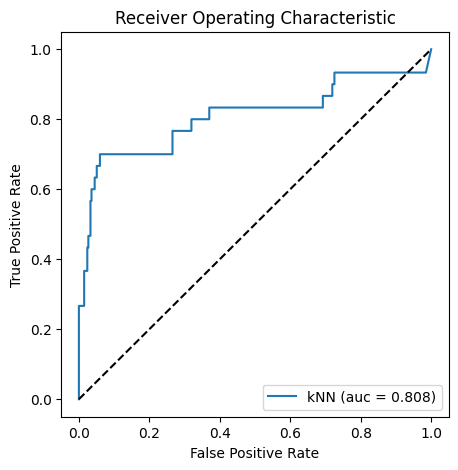


On Test Data:
KNN ROC:0.8083, precision @ rank n:0.6

Outlier prediction information on Test Data: 365 {0: 331, 1: 34}
No of Errors in test set: 26

RMS on Test Set : 0.2668948795168779

MAE on Test Set : 0.07123287671232877


array([[320,  15],
       [ 11,  19]], dtype=int64)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc

classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn = KNN()

# Prediction on training data
model_knn.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction = model_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_knn.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_knn.predict_proba(data_kNN_test)[:,1]
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='kNN (auc = %0.3f)' % auc_kNN)

#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_scores)
unique, counts = np.unique(test_prediction, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_test), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)

from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn.predict(data_kNN_test))

### 3 year test data

In [25]:
# Not on same scale and need to split the data to the train and test part 
Ntest = 1096   # 3 year
train= df.iloc[:-Ntest].copy()
test= df.iloc[-Ntest:].copy()

scaler_temp= RobustScaler()
train['ScaledTemp'] = scaler_temp.fit_transform(train[['temperature']])
test['ScaledTemp'] = scaler_temp.transform(test[['temperature']])

scaler_humid= RobustScaler()
train['ScaledHumid'] = scaler_humid.fit_transform(train[['humidity']])
test['ScaledHumid'] = scaler_humid.transform(test[['humidity']])

scaler_pressure= RobustScaler()
train['ScaledPressure'] = scaler_pressure.fit_transform(train[['pressure']])
test['ScaledPressure'] = scaler_pressure.transform(test[['pressure']])

train_idx = df.index <=train.index[-1]
test_idx = df.index > train.index[-1]

df.loc[train_idx, 'ScaledTemp']= train['ScaledTemp']
df.loc[test_idx, 'ScaledTemp']= test['ScaledTemp']

df.loc[train_idx, 'ScaledHumid']= train['ScaledHumid']
df.loc[test_idx, 'ScaledHumid']= test['ScaledHumid']

df.loc[train_idx, 'ScaledPressure']= train['ScaledPressure']
df.loc[test_idx, 'ScaledPressure']= test['ScaledPressure']

<AxesSubplot: xlabel='date'>

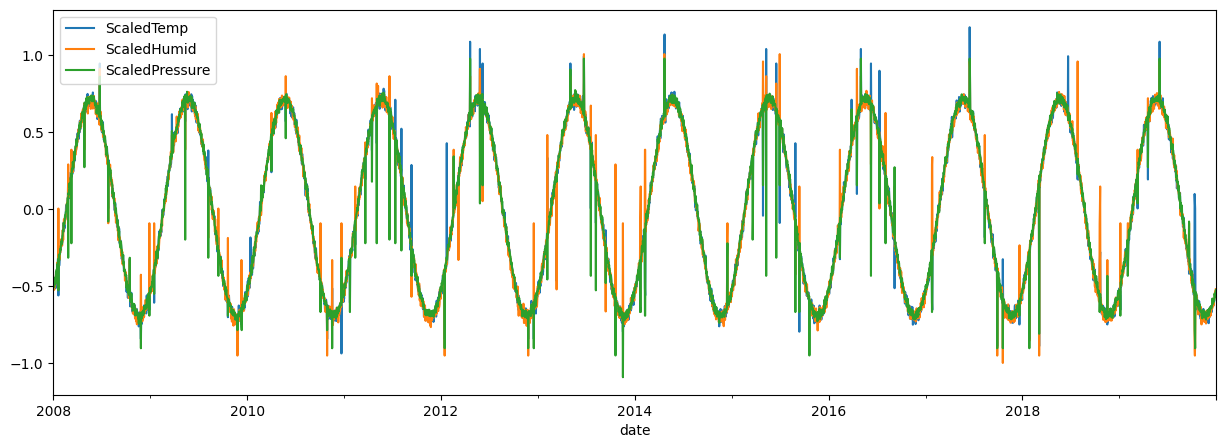

In [26]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
train[cols].plot(figsize=(15,5))

<AxesSubplot: xlabel='date'>

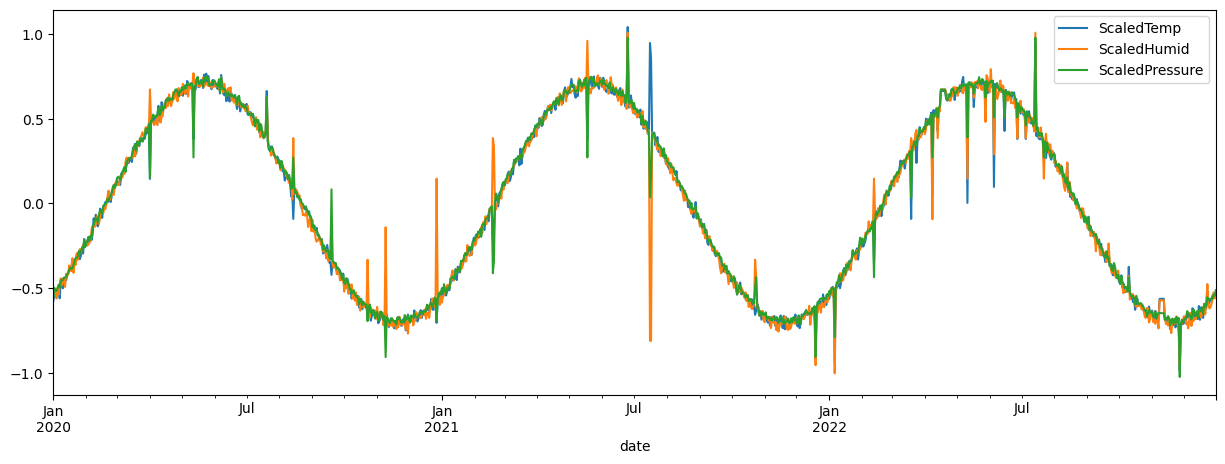

In [27]:
cols = ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']
test[cols].plot(figsize=(15,5))

In [28]:
df_combined=[train[cols],test[cols]]
df_combined=pd.concat(df_combined, axis=0)

In [29]:
for i in range(1, 8):
    df_combined[f'ST_t-{i}'] = df_combined['ScaledTemp'].shift(i)

In [30]:
for i in range(1, 8):
    df_combined[f'SH_t-{i}'] = df_combined['ScaledHumid'].shift(i)

In [31]:
for i in range(1, 8):
    df_combined[f'SP_t-{i}'] = df_combined['ScaledPressure'].shift(i)

In [32]:
df_combined = df_combined.dropna()

In [33]:
# Not on same scale and need to split the data to the train and test part 
nest_samples = 1096  # 3 year
train_data = df_combined.iloc[:-nest_samples].copy()
test_data = df_combined.iloc[-nest_samples:].copy()

In [34]:
features = [col for col in df_combined.columns if col not in ['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]
X_train, y_train = train_data[features], train_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']] #Split into X and Y. training data.

In [35]:
x_test, y_test = test_data[features], test_data[['ScaledTemp', 'ScaledHumid', 'ScaledPressure']]

In [36]:
rf = RandomForestRegressor()
#n_estimators=100, random_state=42

In [37]:
models = []
for i in range(3):
    model = rf
    model.fit(X_train, y_train.iloc[:, i])
    models.append(model)

In [38]:
# Make predictions on the test set for each target variable
y_pred_train = []
for i in range(3):
    y_pred_train.append(models[i].predict(X_train))

In [39]:
# Make predictions on the test set for each target variable
y_pred = []
for i in range(3):
    y_pred.append(models[i].predict(x_test))

In [40]:
# Combine the predictions into a single dataframe on training prediction
df_prediction_train = pd.DataFrame({'Predicted_temperature': y_pred_train[0], 'Predicted_humidity': y_pred_train[1], 'Predicted_pressure': y_pred_train[2]}, index=X_train.index)

In [41]:
# Combine the predictions into a single dataframe
df_prediction = pd.DataFrame({'Predicted_temperature': y_pred[0], 'Predicted_humidity': y_pred[1], 'Predicted_pressure': y_pred[2]}, index=x_test.index)

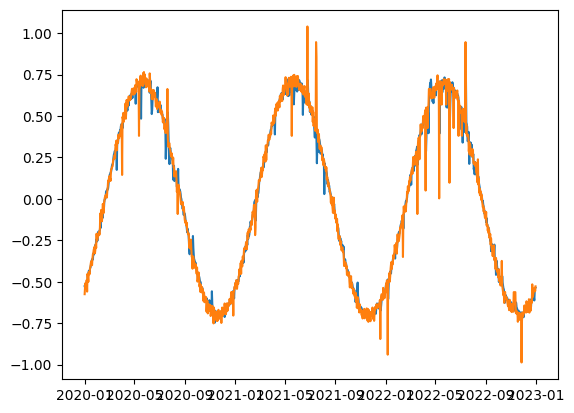

In [42]:
import matplotlib.pyplot as plt
plt.plot(df_prediction['Predicted_temperature'])
plt.plot(y_test['ScaledTemp'])
#plt.plot(df_prediction_train['Predicted_temperature'])

In [43]:
#test_data(Predicted+actual)
data_temp_test = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp']})
data_humidity_test = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid']})
data_pressure_test = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure']})
data_kNN_test=pd.concat([data_temp_test,data_humidity_test,data_pressure_test],axis=1)

In [44]:
nest_samples=1096
le = LabelEncoder()

ground_truth = df_labeled.iloc[:, -1].values
ground_truth_train = ground_truth[:-nest_samples].copy()
ground_truth_test = ground_truth[-nest_samples:].copy()

ground_truth_train = le.fit_transform(ground_truth_train)
ground_truth_test = le.transform(ground_truth_test)

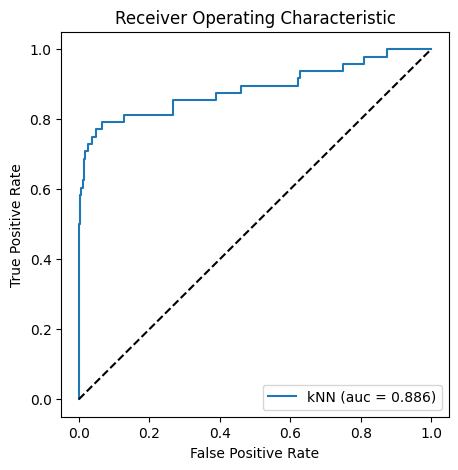


On Test Data:
KNN ROC:0.8862, precision @ rank n:0.6875

Outlier prediction information on Test Data: 1096 {0: 1002, 1: 94}
No of Errors in test set: 68

RMS on Test Set : 0.249085920156957

MAE on Test Set : 0.06204379562043796


array([[991,  57],
       [ 11,  37]], dtype=int64)

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc

classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn = KNN()

# Prediction on training data
model_knn.fit(data_kNN_test, y=None)  # y is ignored in unsupervised setting.
train_prediction = model_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_knn.predict(data_kNN_test) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_knn.predict_proba(data_kNN_test)[:,1]
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='kNN (auc = %0.3f)' % auc_kNN)

#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_scores)
unique, counts = np.unique(test_prediction, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_test), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)

from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn.predict(data_kNN_test))

In [48]:
#test_data(Predicted+actual+residual)
data_temp_ptest = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'actual_temp': y_test['ScaledTemp'], 'residual_temp': (y_test['ScaledTemp'] - df_prediction['Predicted_temperature'])})
data_humidity_ptest = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'actual_humid': y_test['ScaledHumid'], 'residual_humid': (y_test['ScaledHumid'] - df_prediction['Predicted_humidity'])})
data_pressure_ptest = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'actual_pressure': y_test['ScaledPressure'], 'residual_pressure':(y_test['ScaledPressure'] - df_prediction['Predicted_pressure'])})
data_kNN_ptest=pd.concat([data_temp_ptest,data_humidity_ptest,data_pressure_ptest],axis=1)

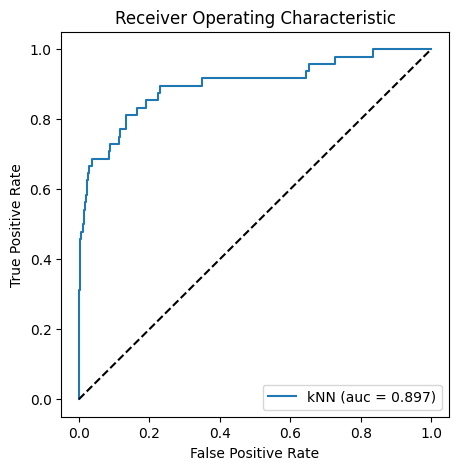


On Test Data:
KNN ROC:0.8971, precision @ rank n:0.5625

Outlier prediction information on Test Data: 1096 {0: 995, 1: 101}
No of Errors in test set: 83

RMS on Test Set : 0.2751907102489095

MAE on Test Set : 0.07572992700729927


array([[980,  68],
       [ 15,  33]], dtype=int64)

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc

classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn = KNN()

# Prediction on training data
model_knn.fit(data_temp_ptest, y=None)  # y is ignored in unsupervised setting.
train_prediction = model_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_knn.predict(data_temp_ptest) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_knn.predict_proba(data_temp_ptest)[:,1]
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='kNN (auc = %0.3f)' % auc_kNN)

#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_scores)
unique, counts = np.unique(test_prediction, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_temp_ptest), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)

from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn.predict(data_temp_ptest))

In [50]:
#test_data(Predicted+residual)
data_temp_wtest = pd.DataFrame({'predicted_temp': df_prediction['Predicted_temperature'], 'residual_temp': (y_test['ScaledTemp'] - df_prediction['Predicted_temperature'])})
data_humidity_wtest = pd.DataFrame({'predicted_humid': df_prediction['Predicted_humidity'], 'residual_humid': (y_test['ScaledHumid'] - df_prediction['Predicted_humidity'])})
data_pressure_wtest = pd.DataFrame({'predicted_pressure': df_prediction['Predicted_pressure'], 'residual_pressure':(y_test['ScaledPressure'] - df_prediction['Predicted_pressure'])})
data_kNN_wtest=pd.concat([data_temp_wtest,data_humidity_wtest,data_pressure_wtest],axis=1)

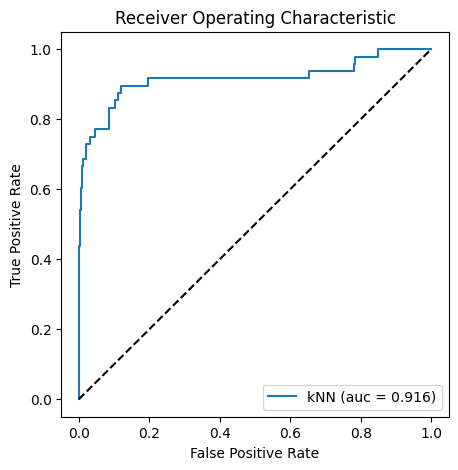


On Test Data:
KNN ROC:0.9159, precision @ rank n:0.6875

Outlier prediction information on Test Data: 1096 {0: 996, 1: 100}
No of Errors in test set: 74

RMS on Test Set : 0.25984273739164326

MAE on Test Set : 0.06751824817518248


array([[985,  63],
       [ 11,  37]], dtype=int64)

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pyod
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.metrics import roc_auc_score,roc_curve,auc

classifier_name = 'KNN'
# model_knn = KNN()  # with default parameters.
model_knn = KNN()

# Prediction on training data
model_knn.fit(data_kNN_wtest, y=None)  # y is ignored in unsupervised setting.
train_prediction = model_knn.labels_  # binary labels (0: inliers, 1: outliers)
train_prediction_scores = model_knn.decision_scores_  # raw outlier scores. The higher, the more abnormal.

# Prediction on test data
test_prediction = model_knn.predict(data_kNN_wtest) # binary labels (0: inliers, 1: outliers)
#test_prediction_scores = model_knn.decision_function(X_test)
test_prediction_scores = model_knn.predict_proba(data_kNN_wtest)[:,1]
# Calculate AUC-ROC score
auc_roc = roc_auc_score(ground_truth_test, test_prediction_scores)
fpr, tpr, thresholds = roc_curve(ground_truth_test, test_prediction_scores)
auc_kNN = auc(fpr,tpr)

plt.figure(figsize=(5,5), dpi=100)
plt.plot(fpr, tpr, linestyle='-', label='kNN (auc = %0.3f)' % auc_kNN)

#plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_roc))
plt.plot([0, 1], [0, 1], 'k--')  # Random ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print("\nOn Test Data:")
evaluate_print(classifier_name, ground_truth_test, test_prediction_scores)
unique, counts = np.unique(test_prediction, return_counts=True)
print("\nOutlier prediction information on Test Data:", len(data_kNN_wtest), dict(zip(unique, counts)))
# no of errors in test set
number_of_errors = (test_prediction != ground_truth_test).sum()
print('No of Errors in test set: {}'.format(number_of_errors))
rms = mean_squared_error(ground_truth_test, test_prediction, squared=False)
mae = mean_absolute_error(ground_truth_test, test_prediction)
print('\nRMS on Test Set :',rms)
print('\nMAE on Test Set :',mae)

from sklearn.metrics import confusion_matrix
confusion_matrix(ground_truth_test, model_knn.predict(data_kNN_wtest))

In [52]:
# Observation: Predicted+residual or predicted+actual worked best.